#Imports and functions

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('bmh')

%config InlineBackend.figure_format = 'svg'

In [ ]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import torch
import random

import torchvision
import time
import copy

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [ ]:
import shutil
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs, task='classification', is_cv=False):

  """
    Trains a PyTorch model for a given number of epochs using the provided criterion, optimizer, and learning rate scheduler.

    Args:
    - model: a PyTorch model
    - criterion: a loss function to be used during training
    - optimizer: an optimizer to be used during training
    - scheduler: a learning rate scheduler
    - num_epochs: the number of training epochs
    - task: the type of task being performed ('classification' or 'regression')
    - is_cv: a flag indicating whether the task is computer vision

    Returns:
    - model: the trained PyTorch model
    - train_losses: a list of training losses for each epoch
    - train_accs: a list of training accuracies for each epoch (or r2 score for regression task)
    - val_losses: a list of validation losses for each epoch
    - val_accs: a list of validation accuracies for each epoch (or r2 score for regression task)
    """

  # Define early stopping
  best_test_loss = np.inf
  patience = 10
  counter = 0

  # Train the model
  train_losses = []
  val_losses = []

  train_accs = []
  val_accs = []

  for epoch in range(num_epochs):
      print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

      # Initialize running loss and accuracy
      running_loss = 0.0
      running_acc = 0.0

      # Loop over training data
      for inputs, targets in tqdm(train_loader):
          # Move inputs and targets to device
          if(is_cv):
            inputs = inputs.to(device)
            targets = targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          if task == 'classification':
            loss = criterion(outputs, targets)
          else:
            loss = criterion(outputs, targets.unsqueeze(1))

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Update running loss
          running_loss += loss.item()

          if task == 'classification':
            outputs_class = outputs.argmax(dim=1)
            running_acc += (outputs_class == targets.data).float().mean().item()
          else:
            running_acc += r2_score(outputs.detach(), targets).item()

      avg_train_loss = running_loss/len(train_loader)
      train_losses.append(avg_train_loss)

      avg_train_acc = running_acc/len(train_loader)
      train_accs.append(avg_train_acc)

      print('Train Loss: {:.4f}'.format(avg_train_loss), flush=True)

      # Evaluate the model on validation data
      model.eval()
      with torch.no_grad():
          test_loss = 0.0
          test_acc = 0.0

          y_true = []
          y_pred = []
          for inputs, targets in tqdm(val_loader):
              if(is_cv):
                inputs = inputs.to(device)
                targets = targets.to(device)

              outputs = model(inputs)
              if task == 'classification':
                test_loss += criterion(outputs, targets).item()
                y_true.extend(targets.tolist())
                y_pred.extend(outputs.argmax(dim=1))#.squeeze().tolist())

                test_acc += (outputs.argmax(dim=1) == targets.data).float().mean().item()

              else:
                test_loss += criterion(outputs, targets.unsqueeze(1)).item()
                y_true.extend(targets.tolist())
                y_pred.extend(outputs.squeeze().tolist())

                test_acc += r2_score(y_pred, y_true).item()

          avg_test_loss = test_loss/len(val_loader)
          val_losses.append(avg_test_loss)

          avg_test_acc = test_acc/len(train_loader)
          val_accs.append(avg_test_acc)

          print('Val Loss: {:.4f}'.format(avg_test_loss), flush=True)

          # Update the learning rate scheduler
          scheduler.step(avg_test_loss)

          # Check if the current test loss is the best so far
          if avg_test_loss < best_test_loss:
              best_test_loss = avg_test_loss
              counter = 0
          else:
              counter += 1

          # Check if early stopping criteria are met
          if counter >= patience:
              print(f'Early stopping after {epoch+1} epochs.')
              break

  return model, train_losses, train_accs, val_losses, val_accs


def test_model(model, criterion, task, is_cv=False):

  """
  Tests a PyTorch model for a given number of epochs using the provided criterion.

  Args:
  - model: a PyTorch model
  - criterion: a loss function to be used during training
  - is_cv: a flag indicating whether the task is computer vision

  Returns:
  - y_true: input targets
  - y_pred: predicted classes
  """

  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      y_true = []
      y_pred = []
      for inputs, targets in tqdm(test_loader):
          if(is_cv):
            inputs = inputs.to(device)
            targets = targets.to(device)

          outputs = model(inputs)
          if task == 'classification':
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            y_true.extend(targets.tolist())
            y_pred.extend(outputs.argmax(dim=1).squeeze().tolist())
          else:
            test_loss += criterion(outputs, targets.unsqueeze(1)).item()
            y_true.extend(targets.tolist())
            y_pred.extend(outputs.squeeze().tolist())
      avg_test_loss = test_loss/len(test_loader)
      print('Test Loss: {:.4f}'.format(avg_test_loss))

      if task == 'classification':
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))
      else:
        print(f'MSE: {mean_squared_error(y_true, y_pred)}, MAE: {mean_absolute_error(y_true, y_pred)}, R2: {r2_score(y_true, y_pred)}')

      return y_true, y_pred

#Basic part

##Regression task

The full EDA and DP with explanations can be found here: https://colab.research.google.com/drive/1ftx4lcmNcSIV9UtOS1nXSxwe_EKX2mUw?usp=sharing.

In [ ]:
def transform(dataset, feature, method):

  '''
    Apply different transformations to a specific feature of a dataset

    dataset: the dataset on which the transformation is to be applied.
    feature: the name of the feature/column in the dataset on which the transformation is to be applied.
    method: the name of the transformation method to be applied. It can be one of the following methods: 'log', 'sqrt', 'cube root', or 'box-cox'.
  '''

  if method == 'log':
    dataset[feature] = np.log(dataset[feature])
  elif method == 'sqrt':
    dataset[feature] = np.sqrt(dataset[feature])
  elif method == 'cube root':
    dataset[feature] = dataset[feature] ** (1/3)
  elif method == 'box-cox':
    dataset[feature] = scipy.stats.boxcox(dataset[feature])[0]

In [ ]:
df_reg = pd.read_csv('/content/gdrive/MyDrive/AirQualityUCI.csv', sep=';')
df_reg.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

###Data preprocessing

Since thare are non-numerical values for features `CO(GT)`, `C6H6(GT)`, `T`, `RH` and `AH` (these features have object type) I convert them to float.

In [ ]:
df_reg['CO(GT)'] = df_reg['CO(GT)'].str.replace(',','.')
df_reg['C6H6(GT)'] = df_reg['C6H6(GT)'].str.replace(',','.')
df_reg['T'] = df_reg['T'].str.replace(',','.')
df_reg['RH'] = df_reg['RH'].str.replace(',','.')
df_reg['AH'] = df_reg['AH'].str.replace(',','.')

df_reg[['CO(GT)','C6H6(GT)', 'T','RH','AH']] = df_reg[['CO(GT)','C6H6(GT)', 'T','RH','AH']].astype(float)

I'll represent date and time as separate features.

In [ ]:
df_reg['Day'] = pd.DatetimeIndex(df_reg['Date']).day
df_reg['Month'] = pd.DatetimeIndex(df_reg['Date']).month
df_reg['Year'] = pd.DatetimeIndex(df_reg['Date']).year

df_reg['Hour']=df_reg['Time'].apply(lambda x: str(x)[0:2])
df_reg['Hour']= df_reg['Hour'].apply(lambda x: float(x) if x != 'na' else np.NaN)

df_reg.drop(['Date', 'Time'], axis=1 , inplace=True)

Features `Unmamed: 15` and `Unnamed: 16` have 0 non-null values so we can drop them.

In [ ]:
df_reg.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1 , inplace=True)

Records in the tail of our dataset are empty so we drop them.

In [ ]:
df_reg.dropna(how='all',inplace=True)

We know that missing values are marked as `-200`. Let's replace them with NaNs.

In [ ]:
df_reg = df_reg.replace(-200,np.NaN)

Since some records are almost empty (including the target) I'll drop them.

In [ ]:
df_reg.dropna(subset=['C6H6(GT)'],inplace=True)

The `NMHC(GT)` feature is 90% empty. Even though it shows a strong correlation with the target, we cannot make conclusions based on this feature, so I'll drop it.

In [ ]:
del df_reg['NMHC(GT)']

As for the features `CO(GT)`, `NoX(GT)`, and `NO2(GT)`, I'll fill the missing values using an interpolation method since our data is time series.

In [ ]:
df_reg['NOx(GT)'].interpolate(method='linear', inplace=True)
df_reg['NO2(GT)'].interpolate(method='linear', inplace=True)
df_reg['CO(GT)'].interpolate(method='linear', inplace=True)

Most of the features are skewed and, accordingly, have outliers. To deal with this, I'd like to apply non-linear transformations.

In [ ]:
df_reg_transformed = df_reg.copy()

transform(df_reg_transformed, 'PT08.S1(CO)', 'log')
transform(df_reg_transformed, 'NOx(GT)', 'cube root')
transform(df_reg_transformed, 'PT08.S5(O3)', 'cube root')
transform(df_reg_transformed, 'PT08.S4(NO2)', 'sqrt')
transform(df_reg_transformed, 'PT08.S3(NOx)', 'log')
transform(df_reg_transformed, 'PT08.S2(NMHC)', 'log')
transform(df_reg_transformed, 'CO(GT)', 'cube root')

transform(df_reg_transformed, 'C6H6(GT)', 'box-cox')

Now we'll form the X and y datasets.

In [ ]:
features = df_reg_transformed.select_dtypes(exclude=['category', 'object']).columns.tolist()
features.remove('C6H6(GT)')
features

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH',
 'Day',
 'Month',
 'Year',
 'Hour']

In [ ]:
X = df_reg_transformed[features]
y = df_reg_transformed['C6H6(GT)']

Split into train and test subsets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False)

And scale.

In [ ]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

Since there is multicollinearity in our dataset, we have to remove features that are highly correlated with each other in order to build a regression. I'll use `variance_inflation_factor` as a measure for multicollinearity.

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

vif_data

feature        VIF
0          CO(GT)   5.314539
1     PT08.S1(CO)   8.612043
2   PT08.S2(NMHC)  25.782587
3         NOx(GT)   8.310745
4    PT08.S3(NOx)  11.429970
5         NO2(GT)   4.512767
6    PT08.S4(NO2)  10.391964
7     PT08.S5(O3)   9.667579
8               T  15.107850
9              RH  12.600228
10             AH  10.062215
11            Day   1.057718
12          Month   1.325384
13           Year        NaN
14           Hour   1.548144

According to documentation, if VIF is greater than 5, then the explanatory variable is highly collinear with the other explanatory variables. That's why we'll remove `PT08.S1(CO)`, `NOx(GT)`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `RH` and `PT08.S5(O3)`. Also we drop the features that have the least correlation with the target according to the correlation matrix received earlier.



In [ ]:
X_train = X_train.drop([1, 3, 4, 6, 7, 9], axis=1)
X_test = X_test.drop([1, 3, 4, 6, 7, 9], axis=1)

X_train.drop([11, 12, 13], axis=1 , inplace=True)
X_test.drop([11, 12, 13], axis=1 , inplace=True)

Now we'll split the train dataset into two parts: train and validation. (The training set is the data on which the machine learning algorithm is trained, and the validation set is used to evaluate the performance of the model on unseen data).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Now we should convert the training, validation, and test data to PyTorch tensors using the torch.FloatTensor() method.

PyTorch tensors are the fundamental data structure in PyTorch. By converting the data to PyTorch tensors, we can train PyTorch models using the data.

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_val = torch.FloatTensor(X_val.values)
X_test = torch.FloatTensor(X_test.values)

y_train = torch.FloatTensor(y_train.values)
y_val = torch.FloatTensor(y_val.values)
y_test = torch.FloatTensor(y_test.values)

Now we prepare the data for training, validation, and testing using `DataLoader`. The `TensorDataset` is used to combine the input data and targets into a single dataset for each set. Using `DataLoader`, we allow the model to train, validate, and test on batches of data rather than the entire dataset at once. The `batch_size` parameter is used to specify the number of samples per batch.

In [ ]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

###Model

Now we can create the model. The model should be implemented as a subclass of the `nn.Module`. It will consist of three fully connected layers with batch-normalization after first two layers. As an activation function, I'll use ReLU. The forward method performs the forward pass of the network, taking an input tensor and passing it through the model steps.

In [ ]:
class AirQualityModel(nn.Module):
    def __init__(self, input_size):
        super(AirQualityModel, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)

        return out

`L1Loss`: the loss function for the regression problem, which computes the mean absolute error between the predicted and true values.

`torch.optim.SGD`: the stochastic gradient descent optimizer, which updates the parameters of the model based on the gradients of the loss function with respect to the parameters.

`ReduceLROnPlateau`: a learning rate scheduler, which adjusts the learning rate of the optimizer based on the validation loss of the model. The learning rate is reduced by a factor of 0.5 if the validation loss does not improve for 5 epochs.

In [ ]:
model = AirQualityModel(input_size=X_train.shape[1])
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

model, _, _, _, _ = train_model(model, criterion, optimizer, scheduler, 200, 'regression')

Epoch 0/199:


100%|██████████| 79/79 [00:00<00:00, 480.79it/s]

Train Loss: 2.7165



100%|██████████| 20/20 [00:00<00:00, 633.75it/s]

Val Loss: 2.3638
Epoch 1/199:



100%|██████████| 79/79 [00:00<00:00, 495.83it/s]

Train Loss: 1.3257



100%|██████████| 20/20 [00:00<00:00, 624.12it/s]

Val Loss: 0.7692
Epoch 2/199:



100%|██████████| 79/79 [00:00<00:00, 494.65it/s]

Train Loss: 0.5881



100%|██████████| 20/20 [00:00<00:00, 580.80it/s]

Val Loss: 0.4598
Epoch 3/199:



100%|██████████| 79/79 [00:00<00:00, 456.28it/s]

Train Loss: 0.3998



100%|██████████| 20/20 [00:00<00:00, 595.64it/s]

Val Loss: 0.3455
Epoch 4/199:



100%|██████████| 79/79 [00:00<00:00, 448.31it/s]

Train Loss: 0.3173



100%|██████████| 20/20 [00:00<00:00, 608.95it/s]

Val Loss: 0.2788
Epoch 5/199:



100%|██████████| 79/79 [00:00<00:00, 520.61it/s]

Train Loss: 0.2494



100%|██████████| 20/20 [00:00<00:00, 658.37it/s]

Val Loss: 0.2130
Epoch 6/199:



100%|██████████| 79/79 [00:00<00:00, 490.66it/s]

Train Loss: 0.1888



100%|██████████| 20/20 [00:00<00:00, 579.08it/s]

Val Loss: 0.1639
Epoch 7/199:



100%|██████████| 79/79 [00:00<00:00, 477.35it/s]

Train Loss: 0.1436



100%|██████████| 20/20 [00:00<00:00, 588.61it/s]

Val Loss: 0.1292
Epoch 8/199:



100%|██████████| 79/79 [00:00<00:00, 476.72it/s]

Train Loss: 0.1157



100%|██████████| 20/20 [00:00<00:00, 584.34it/s]

Val Loss: 0.1098
Epoch 9/199:



100%|██████████| 79/79 [00:00<00:00, 496.47it/s]

Train Loss: 0.1029



100%|██████████| 20/20 [00:00<00:00, 595.24it/s]

Val Loss: 0.0989
Epoch 10/199:



100%|██████████| 79/79 [00:00<00:00, 443.98it/s]

Train Loss: 0.0972



100%|██████████| 20/20 [00:00<00:00, 615.01it/s]

Val Loss: 0.0959
Epoch 11/199:



100%|██████████| 79/79 [00:00<00:00, 452.70it/s]

Train Loss: 0.0936



100%|██████████| 20/20 [00:00<00:00, 609.35it/s]

Val Loss: 0.0938
Epoch 12/199:



100%|██████████| 79/79 [00:00<00:00, 341.68it/s]

Train Loss: 0.0897



100%|██████████| 20/20 [00:00<00:00, 440.84it/s]

Val Loss: 0.1018
Epoch 13/199:



100%|██████████| 79/79 [00:00<00:00, 343.92it/s]

Train Loss: 0.0868



100%|██████████| 20/20 [00:00<00:00, 450.12it/s]

Val Loss: 0.0909
Epoch 14/199:



100%|██████████| 79/79 [00:00<00:00, 340.40it/s]

Train Loss: 0.0849



100%|██████████| 20/20 [00:00<00:00, 450.34it/s]

Val Loss: 0.1139
Epoch 15/199:



100%|██████████| 79/79 [00:00<00:00, 345.61it/s]

Train Loss: 0.0892



100%|██████████| 20/20 [00:00<00:00, 465.91it/s]

Val Loss: 0.0962
Epoch 16/199:



100%|██████████| 79/79 [00:00<00:00, 348.26it/s]

Train Loss: 0.0850



100%|██████████| 20/20 [00:00<00:00, 468.84it/s]

Val Loss: 0.0970
Epoch 17/199:



100%|██████████| 79/79 [00:00<00:00, 339.65it/s]

Train Loss: 0.0875



100%|██████████| 20/20 [00:00<00:00, 433.88it/s]

Val Loss: 0.0849
Epoch 18/199:



100%|██████████| 79/79 [00:00<00:00, 330.55it/s]

Train Loss: 0.0848



100%|██████████| 20/20 [00:00<00:00, 434.85it/s]

Val Loss: 0.0753
Epoch 19/199:



100%|██████████| 79/79 [00:00<00:00, 347.83it/s]

Train Loss: 0.0869



100%|██████████| 20/20 [00:00<00:00, 463.56it/s]

Val Loss: 0.0672
Epoch 20/199:



100%|██████████| 79/79 [00:00<00:00, 347.56it/s]

Train Loss: 0.0834



100%|██████████| 20/20 [00:00<00:00, 458.92it/s]

Val Loss: 0.0914
Epoch 21/199:



100%|██████████| 79/79 [00:00<00:00, 348.42it/s]

Train Loss: 0.0855



100%|██████████| 20/20 [00:00<00:00, 500.85it/s]

Val Loss: 0.0889
Epoch 22/199:



100%|██████████| 79/79 [00:00<00:00, 345.90it/s]

Train Loss: 0.0839



100%|██████████| 20/20 [00:00<00:00, 471.25it/s]

Val Loss: 0.0990
Epoch 23/199:



100%|██████████| 79/79 [00:00<00:00, 349.20it/s]

Train Loss: 0.0827



100%|██████████| 20/20 [00:00<00:00, 477.10it/s]

Val Loss: 0.0842
Epoch 24/199:



100%|██████████| 79/79 [00:00<00:00, 352.43it/s]

Train Loss: 0.0822



100%|██████████| 20/20 [00:00<00:00, 500.05it/s]

Val Loss: 0.0854
Epoch 25/199:



100%|██████████| 79/79 [00:00<00:00, 341.49it/s]

Train Loss: 0.0891



100%|██████████| 20/20 [00:00<00:00, 470.10it/s]

Val Loss: 0.0881
Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.
Epoch 26/199:



100%|██████████| 79/79 [00:00<00:00, 346.47it/s]

Train Loss: 0.0576



100%|██████████| 20/20 [00:00<00:00, 480.70it/s]

Val Loss: 0.0591
Epoch 27/199:



100%|██████████| 79/79 [00:00<00:00, 345.54it/s]

Train Loss: 0.0561



100%|██████████| 20/20 [00:00<00:00, 499.99it/s]

Val Loss: 0.0600
Epoch 28/199:



100%|██████████| 79/79 [00:00<00:00, 326.00it/s]

Train Loss: 0.0552



100%|██████████| 20/20 [00:00<00:00, 434.56it/s]

Val Loss: 0.0585
Epoch 29/199:



100%|██████████| 79/79 [00:00<00:00, 322.77it/s]

Train Loss: 0.0550



100%|██████████| 20/20 [00:00<00:00, 476.62it/s]

Val Loss: 0.0561
Epoch 30/199:



100%|██████████| 79/79 [00:00<00:00, 356.92it/s]

Train Loss: 0.0544



100%|██████████| 20/20 [00:00<00:00, 662.15it/s]

Val Loss: 0.0616
Epoch 31/199:



100%|██████████| 79/79 [00:00<00:00, 477.11it/s]

Train Loss: 0.0534



100%|██████████| 20/20 [00:00<00:00, 599.88it/s]

Val Loss: 0.0631
Epoch 32/199:



100%|██████████| 79/79 [00:00<00:00, 497.64it/s]

Train Loss: 0.0529



100%|██████████| 20/20 [00:00<00:00, 639.89it/s]

Val Loss: 0.0557
Epoch 33/199:



100%|██████████| 79/79 [00:00<00:00, 463.47it/s]

Train Loss: 0.0523



100%|██████████| 20/20 [00:00<00:00, 614.56it/s]

Val Loss: 0.0555
Epoch 34/199:



100%|██████████| 79/79 [00:00<00:00, 477.19it/s]

Train Loss: 0.0525



100%|██████████| 20/20 [00:00<00:00, 586.85it/s]

Val Loss: 0.0550
Epoch 35/199:



100%|██████████| 79/79 [00:00<00:00, 489.23it/s]

Train Loss: 0.0515



100%|██████████| 20/20 [00:00<00:00, 619.71it/s]

Val Loss: 0.0538
Epoch 36/199:



100%|██████████| 79/79 [00:00<00:00, 481.01it/s]

Train Loss: 0.0512



100%|██████████| 20/20 [00:00<00:00, 543.91it/s]

Val Loss: 0.0612
Epoch 37/199:



100%|██████████| 79/79 [00:00<00:00, 460.51it/s]

Train Loss: 0.0500



100%|██████████| 20/20 [00:00<00:00, 591.29it/s]

Val Loss: 0.0521
Epoch 38/199:



100%|██████████| 79/79 [00:00<00:00, 452.06it/s]

Train Loss: 0.0496



100%|██████████| 20/20 [00:00<00:00, 485.61it/s]

Val Loss: 0.0713
Epoch 39/199:



100%|██████████| 79/79 [00:00<00:00, 449.42it/s]

Train Loss: 0.0504



100%|██████████| 20/20 [00:00<00:00, 602.28it/s]

Val Loss: 0.0541
Epoch 40/199:



100%|██████████| 79/79 [00:00<00:00, 482.29it/s]

Train Loss: 0.0493



100%|██████████| 20/20 [00:00<00:00, 463.73it/s]

Val Loss: 0.0515
Epoch 41/199:



100%|██████████| 79/79 [00:00<00:00, 456.59it/s]

Train Loss: 0.0484



100%|██████████| 20/20 [00:00<00:00, 537.19it/s]

Val Loss: 0.0517
Epoch 42/199:



100%|██████████| 79/79 [00:00<00:00, 425.72it/s]

Train Loss: 0.0485



100%|██████████| 20/20 [00:00<00:00, 588.68it/s]

Val Loss: 0.0494
Epoch 43/199:



100%|██████████| 79/79 [00:00<00:00, 490.84it/s]

Train Loss: 0.0478



100%|██████████| 20/20 [00:00<00:00, 603.35it/s]

Val Loss: 0.0604
Epoch 44/199:



100%|██████████| 79/79 [00:00<00:00, 485.57it/s]

Train Loss: 0.0473



100%|██████████| 20/20 [00:00<00:00, 583.79it/s]

Val Loss: 0.0490
Epoch 45/199:



100%|██████████| 79/79 [00:00<00:00, 497.19it/s]

Train Loss: 0.0472



100%|██████████| 20/20 [00:00<00:00, 654.36it/s]

Val Loss: 0.0498
Epoch 46/199:



100%|██████████| 79/79 [00:00<00:00, 459.59it/s]

Train Loss: 0.0471



100%|██████████| 20/20 [00:00<00:00, 593.60it/s]

Val Loss: 0.0595
Epoch 47/199:



100%|██████████| 79/79 [00:00<00:00, 479.02it/s]

Train Loss: 0.0462



100%|██████████| 20/20 [00:00<00:00, 620.41it/s]

Val Loss: 0.0499
Epoch 48/199:



100%|██████████| 79/79 [00:00<00:00, 483.91it/s]

Train Loss: 0.0462



100%|██████████| 20/20 [00:00<00:00, 542.56it/s]

Val Loss: 0.0482
Epoch 49/199:



100%|██████████| 79/79 [00:00<00:00, 490.61it/s]

Train Loss: 0.0460



100%|██████████| 20/20 [00:00<00:00, 641.81it/s]

Val Loss: 0.0473
Epoch 50/199:



100%|██████████| 79/79 [00:00<00:00, 461.24it/s]

Train Loss: 0.0457



100%|██████████| 20/20 [00:00<00:00, 647.17it/s]

Val Loss: 0.0481
Epoch 51/199:



100%|██████████| 79/79 [00:00<00:00, 447.74it/s]

Train Loss: 0.0458



100%|██████████| 20/20 [00:00<00:00, 577.11it/s]

Val Loss: 0.0524
Epoch 52/199:



100%|██████████| 79/79 [00:00<00:00, 462.69it/s]

Train Loss: 0.0452



100%|██████████| 20/20 [00:00<00:00, 566.36it/s]

Val Loss: 0.0490
Epoch 53/199:



100%|██████████| 79/79 [00:00<00:00, 451.59it/s]

Train Loss: 0.0438



100%|██████████| 20/20 [00:00<00:00, 477.16it/s]

Val Loss: 0.0456
Epoch 54/199:



100%|██████████| 79/79 [00:00<00:00, 447.55it/s]

Train Loss: 0.0444



100%|██████████| 20/20 [00:00<00:00, 548.12it/s]

Val Loss: 0.0587
Epoch 55/199:



100%|██████████| 79/79 [00:00<00:00, 443.31it/s]

Train Loss: 0.0455



100%|██████████| 20/20 [00:00<00:00, 617.10it/s]

Val Loss: 0.0481
Epoch 56/199:



100%|██████████| 79/79 [00:00<00:00, 454.08it/s]

Train Loss: 0.0441



100%|██████████| 20/20 [00:00<00:00, 621.14it/s]

Val Loss: 0.0447
Epoch 57/199:



100%|██████████| 79/79 [00:00<00:00, 460.92it/s]

Train Loss: 0.0420



100%|██████████| 20/20 [00:00<00:00, 569.18it/s]

Val Loss: 0.0447
Epoch 58/199:



100%|██████████| 79/79 [00:00<00:00, 470.98it/s]

Train Loss: 0.0436



100%|██████████| 20/20 [00:00<00:00, 553.79it/s]

Val Loss: 0.0450
Epoch 59/199:



100%|██████████| 79/79 [00:00<00:00, 493.56it/s]

Train Loss: 0.0428



100%|██████████| 20/20 [00:00<00:00, 495.45it/s]

Val Loss: 0.0447
Epoch 60/199:



100%|██████████| 79/79 [00:00<00:00, 479.99it/s]

Train Loss: 0.0431



100%|██████████| 20/20 [00:00<00:00, 573.36it/s]

Val Loss: 0.0516
Epoch 61/199:



100%|██████████| 79/79 [00:00<00:00, 480.28it/s]

Train Loss: 0.0432



100%|██████████| 20/20 [00:00<00:00, 542.00it/s]

Val Loss: 0.0450
Epoch 62/199:



100%|██████████| 79/79 [00:00<00:00, 471.96it/s]

Train Loss: 0.0428



100%|██████████| 20/20 [00:00<00:00, 559.08it/s]

Val Loss: 0.0436
Epoch 63/199:



100%|██████████| 79/79 [00:00<00:00, 472.31it/s]

Train Loss: 0.0416



100%|██████████| 20/20 [00:00<00:00, 581.61it/s]

Val Loss: 0.0462
Epoch 64/199:



100%|██████████| 79/79 [00:00<00:00, 482.72it/s]

Train Loss: 0.0414



100%|██████████| 20/20 [00:00<00:00, 498.19it/s]

Val Loss: 0.0440
Epoch 65/199:



100%|██████████| 79/79 [00:00<00:00, 480.62it/s]

Train Loss: 0.0433



100%|██████████| 20/20 [00:00<00:00, 544.02it/s]

Val Loss: 0.0424
Epoch 66/199:



100%|██████████| 79/79 [00:00<00:00, 493.74it/s]

Train Loss: 0.0424



100%|██████████| 20/20 [00:00<00:00, 653.06it/s]

Val Loss: 0.0481
Epoch 67/199:



100%|██████████| 79/79 [00:00<00:00, 497.10it/s]

Train Loss: 0.0422



100%|██████████| 20/20 [00:00<00:00, 544.68it/s]

Val Loss: 0.0450
Epoch 68/199:



100%|██████████| 79/79 [00:00<00:00, 519.73it/s]

Train Loss: 0.0417



100%|██████████| 20/20 [00:00<00:00, 576.19it/s]

Val Loss: 0.0438
Epoch 69/199:



100%|██████████| 79/79 [00:00<00:00, 462.80it/s]

Train Loss: 0.0440



100%|██████████| 20/20 [00:00<00:00, 614.60it/s]

Val Loss: 0.0533
Epoch 70/199:



100%|██████████| 79/79 [00:00<00:00, 506.11it/s]

Train Loss: 0.0408



100%|██████████| 20/20 [00:00<00:00, 594.93it/s]

Val Loss: 0.0416
Epoch 71/199:



100%|██████████| 79/79 [00:00<00:00, 475.08it/s]

Train Loss: 0.0418



100%|██████████| 20/20 [00:00<00:00, 592.90it/s]

Val Loss: 0.0433
Epoch 72/199:



100%|██████████| 79/79 [00:00<00:00, 495.14it/s]

Train Loss: 0.0405



100%|██████████| 20/20 [00:00<00:00, 525.70it/s]

Val Loss: 0.0496
Epoch 73/199:



100%|██████████| 79/79 [00:00<00:00, 468.70it/s]

Train Loss: 0.0407



100%|██████████| 20/20 [00:00<00:00, 614.69it/s]

Val Loss: 0.0423
Epoch 74/199:



100%|██████████| 79/79 [00:00<00:00, 430.65it/s]

Train Loss: 0.0404



100%|██████████| 20/20 [00:00<00:00, 565.99it/s]

Val Loss: 0.0414
Epoch 75/199:



100%|██████████| 79/79 [00:00<00:00, 334.85it/s]

Train Loss: 0.0398



100%|██████████| 20/20 [00:00<00:00, 528.52it/s]

Val Loss: 0.0418
Epoch 76/199:



100%|██████████| 79/79 [00:00<00:00, 330.62it/s]

Train Loss: 0.0404



100%|██████████| 20/20 [00:00<00:00, 514.71it/s]

Val Loss: 0.0404
Epoch 77/199:



100%|██████████| 79/79 [00:00<00:00, 324.90it/s]

Train Loss: 0.0412



100%|██████████| 20/20 [00:00<00:00, 476.69it/s]

Val Loss: 0.0523
Epoch 78/199:



100%|██████████| 79/79 [00:00<00:00, 352.95it/s]

Train Loss: 0.0405



100%|██████████| 20/20 [00:00<00:00, 481.05it/s]

Val Loss: 0.0399
Epoch 79/199:



100%|██████████| 79/79 [00:00<00:00, 342.37it/s]

Train Loss: 0.0391



100%|██████████| 20/20 [00:00<00:00, 468.95it/s]

Val Loss: 0.0457
Epoch 80/199:



100%|██████████| 79/79 [00:00<00:00, 334.20it/s]

Train Loss: 0.0406



100%|██████████| 20/20 [00:00<00:00, 419.13it/s]

Val Loss: 0.0412
Epoch 81/199:



100%|██████████| 79/79 [00:00<00:00, 328.97it/s]

Train Loss: 0.0399



100%|██████████| 20/20 [00:00<00:00, 455.30it/s]

Val Loss: 0.0419
Epoch 82/199:



100%|██████████| 79/79 [00:00<00:00, 333.84it/s]

Train Loss: 0.0383



100%|██████████| 20/20 [00:00<00:00, 451.21it/s]

Val Loss: 0.0407
Epoch 83/199:



100%|██████████| 79/79 [00:00<00:00, 325.52it/s]

Train Loss: 0.0393



100%|██████████| 20/20 [00:00<00:00, 367.16it/s]

Val Loss: 0.0415
Epoch 84/199:



100%|██████████| 79/79 [00:00<00:00, 339.95it/s]

Train Loss: 0.0394



100%|██████████| 20/20 [00:00<00:00, 478.61it/s]

Val Loss: 0.0385
Epoch 85/199:



100%|██████████| 79/79 [00:00<00:00, 335.27it/s]

Train Loss: 0.0404



100%|██████████| 20/20 [00:00<00:00, 486.40it/s]

Val Loss: 0.0384
Epoch 86/199:



100%|██████████| 79/79 [00:00<00:00, 341.35it/s]

Train Loss: 0.0391



100%|██████████| 20/20 [00:00<00:00, 372.50it/s]

Val Loss: 0.0523
Epoch 87/199:



100%|██████████| 79/79 [00:00<00:00, 334.26it/s]

Train Loss: 0.0397



100%|██████████| 20/20 [00:00<00:00, 454.99it/s]

Val Loss: 0.0389
Epoch 88/199:



100%|██████████| 79/79 [00:00<00:00, 338.43it/s]

Train Loss: 0.0377



100%|██████████| 20/20 [00:00<00:00, 434.80it/s]

Val Loss: 0.0394
Epoch 89/199:



100%|██████████| 79/79 [00:00<00:00, 326.21it/s]

Train Loss: 0.0385



100%|██████████| 20/20 [00:00<00:00, 477.27it/s]

Val Loss: 0.0482
Epoch 90/199:



100%|██████████| 79/79 [00:00<00:00, 341.07it/s]

Train Loss: 0.0399



100%|██████████| 20/20 [00:00<00:00, 477.26it/s]

Val Loss: 0.0387
Epoch 91/199:



100%|██████████| 79/79 [00:00<00:00, 348.26it/s]

Train Loss: 0.0394



100%|██████████| 20/20 [00:00<00:00, 469.59it/s]

Val Loss: 0.0383
Epoch 92/199:



100%|██████████| 79/79 [00:00<00:00, 317.24it/s]

Train Loss: 0.0383



100%|██████████| 20/20 [00:00<00:00, 463.21it/s]

Val Loss: 0.0379
Epoch 93/199:



100%|██████████| 79/79 [00:00<00:00, 311.85it/s]

Train Loss: 0.0416



100%|██████████| 20/20 [00:00<00:00, 408.49it/s]

Val Loss: 0.0378
Epoch 94/199:



100%|██████████| 79/79 [00:00<00:00, 386.66it/s]

Train Loss: 0.0385



100%|██████████| 20/20 [00:00<00:00, 667.86it/s]

Val Loss: 0.0505
Epoch 95/199:



100%|██████████| 79/79 [00:00<00:00, 473.46it/s]

Train Loss: 0.0380



100%|██████████| 20/20 [00:00<00:00, 452.19it/s]

Val Loss: 0.0428
Epoch 96/199:



100%|██████████| 79/79 [00:00<00:00, 466.70it/s]

Train Loss: 0.0370



100%|██████████| 20/20 [00:00<00:00, 511.44it/s]

Val Loss: 0.0409
Epoch 97/199:



100%|██████████| 79/79 [00:00<00:00, 481.20it/s]

Train Loss: 0.0394



100%|██████████| 20/20 [00:00<00:00, 500.39it/s]

Val Loss: 0.0388
Epoch 98/199:



100%|██████████| 79/79 [00:00<00:00, 462.64it/s]

Train Loss: 0.0384



100%|██████████| 20/20 [00:00<00:00, 506.48it/s]

Val Loss: 0.0433
Epoch 99/199:



100%|██████████| 79/79 [00:00<00:00, 484.30it/s]

Train Loss: 0.0378



100%|██████████| 20/20 [00:00<00:00, 634.81it/s]

Val Loss: 0.0563
Epoch 00100: reducing learning rate of group 0 to 2.5000e-04.
Epoch 100/199:



100%|██████████| 79/79 [00:00<00:00, 409.86it/s]

Train Loss: 0.0330



100%|██████████| 20/20 [00:00<00:00, 551.64it/s]

Val Loss: 0.0363
Epoch 101/199:



100%|██████████| 79/79 [00:00<00:00, 439.81it/s]

Train Loss: 0.0328



100%|██████████| 20/20 [00:00<00:00, 566.04it/s]

Val Loss: 0.0380
Epoch 102/199:



100%|██████████| 79/79 [00:00<00:00, 441.77it/s]

Train Loss: 0.0327



100%|██████████| 20/20 [00:00<00:00, 445.03it/s]

Val Loss: 0.0360
Epoch 103/199:



100%|██████████| 79/79 [00:00<00:00, 452.72it/s]

Train Loss: 0.0323



100%|██████████| 20/20 [00:00<00:00, 509.47it/s]

Val Loss: 0.0362
Epoch 104/199:



100%|██████████| 79/79 [00:00<00:00, 333.50it/s]

Train Loss: 0.0325



100%|██████████| 20/20 [00:00<00:00, 462.87it/s]

Val Loss: 0.0355
Epoch 105/199:



100%|██████████| 79/79 [00:00<00:00, 301.97it/s]

Train Loss: 0.0324



100%|██████████| 20/20 [00:00<00:00, 490.52it/s]

Val Loss: 0.0372
Epoch 106/199:



100%|██████████| 79/79 [00:00<00:00, 352.60it/s]

Train Loss: 0.0324



100%|██████████| 20/20 [00:00<00:00, 463.26it/s]

Val Loss: 0.0364
Epoch 107/199:



100%|██████████| 79/79 [00:00<00:00, 345.05it/s]

Train Loss: 0.0322



100%|██████████| 20/20 [00:00<00:00, 452.38it/s]

Val Loss: 0.0358
Epoch 108/199:



100%|██████████| 79/79 [00:00<00:00, 304.66it/s]

Train Loss: 0.0321



100%|██████████| 20/20 [00:00<00:00, 441.08it/s]

Val Loss: 0.0366
Epoch 109/199:



100%|██████████| 79/79 [00:00<00:00, 335.24it/s]

Train Loss: 0.0320



100%|██████████| 20/20 [00:00<00:00, 482.64it/s]

Val Loss: 0.0363
Epoch 110/199:



100%|██████████| 79/79 [00:00<00:00, 332.37it/s]

Train Loss: 0.0320



100%|██████████| 20/20 [00:00<00:00, 486.98it/s]

Val Loss: 0.0369
Epoch 00111: reducing learning rate of group 0 to 1.2500e-04.
Epoch 111/199:



100%|██████████| 79/79 [00:00<00:00, 335.77it/s]

Train Loss: 0.0315



100%|██████████| 20/20 [00:00<00:00, 383.32it/s]

Val Loss: 0.0355
Epoch 112/199:



100%|██████████| 79/79 [00:00<00:00, 347.61it/s]

Train Loss: 0.0314



100%|██████████| 20/20 [00:00<00:00, 464.92it/s]

Val Loss: 0.0350
Epoch 113/199:



100%|██████████| 79/79 [00:00<00:00, 317.51it/s]

Train Loss: 0.0313



100%|██████████| 20/20 [00:00<00:00, 412.80it/s]

Val Loss: 0.0354
Epoch 114/199:



100%|██████████| 79/79 [00:00<00:00, 359.07it/s]

Train Loss: 0.0313



100%|██████████| 20/20 [00:00<00:00, 466.91it/s]

Val Loss: 0.0352
Epoch 115/199:



100%|██████████| 79/79 [00:00<00:00, 325.69it/s]

Train Loss: 0.0312



100%|██████████| 20/20 [00:00<00:00, 447.34it/s]

Val Loss: 0.0352
Epoch 116/199:



100%|██████████| 79/79 [00:00<00:00, 333.06it/s]

Train Loss: 0.0312



100%|██████████| 20/20 [00:00<00:00, 381.68it/s]

Val Loss: 0.0352


Epoch 117/199:


100%|██████████| 79/79 [00:00<00:00, 314.03it/s]

Train Loss: 0.0312



100%|██████████| 20/20 [00:00<00:00, 483.96it/s]

Val Loss: 0.0352
Epoch 118/199:



100%|██████████| 79/79 [00:00<00:00, 304.54it/s]

Train Loss: 0.0311



100%|██████████| 20/20 [00:00<00:00, 312.25it/s]

Val Loss: 0.0350
Epoch 00119: reducing learning rate of group 0 to 6.2500e-05.
Epoch 119/199:



100%|██████████| 79/79 [00:00<00:00, 314.67it/s]

Train Loss: 0.0309



100%|██████████| 20/20 [00:00<00:00, 437.10it/s]

Val Loss: 0.0350
Epoch 120/199:



100%|██████████| 79/79 [00:00<00:00, 311.52it/s]

Train Loss: 0.0309



100%|██████████| 20/20 [00:00<00:00, 463.68it/s]

Val Loss: 0.0350
Epoch 121/199:



100%|██████████| 79/79 [00:00<00:00, 320.94it/s]

Train Loss: 0.0309



100%|██████████| 20/20 [00:00<00:00, 421.44it/s]

Val Loss: 0.0350
Epoch 122/199:



100%|██████████| 79/79 [00:00<00:00, 318.40it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 401.32it/s]

Val Loss: 0.0348
Epoch 123/199:



100%|██████████| 79/79 [00:00<00:00, 310.80it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 523.43it/s]

Val Loss: 0.0349
Epoch 124/199:



100%|██████████| 79/79 [00:00<00:00, 457.67it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 541.54it/s]

Val Loss: 0.0348
Epoch 125/199:



100%|██████████| 79/79 [00:00<00:00, 444.34it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 517.39it/s]

Val Loss: 0.0348
Epoch 126/199:



100%|██████████| 79/79 [00:00<00:00, 426.89it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 498.20it/s]

Val Loss: 0.0348
Epoch 127/199:



100%|██████████| 79/79 [00:00<00:00, 446.66it/s]

Train Loss: 0.0308



100%|██████████| 20/20 [00:00<00:00, 565.11it/s]

Val Loss: 0.0350
Epoch 128/199:



100%|██████████| 79/79 [00:00<00:00, 453.16it/s]

Train Loss: 0.0307



100%|██████████| 20/20 [00:00<00:00, 534.02it/s]

Val Loss: 0.0348
Epoch 129/199:



100%|██████████| 79/79 [00:00<00:00, 480.40it/s]

Train Loss: 0.0307



100%|██████████| 20/20 [00:00<00:00, 482.86it/s]

Val Loss: 0.0347
Epoch 130/199:



100%|██████████| 79/79 [00:00<00:00, 440.37it/s]

Train Loss: 0.0307



100%|██████████| 20/20 [00:00<00:00, 431.93it/s]

Val Loss: 0.0349
Epoch 131/199:



100%|██████████| 79/79 [00:00<00:00, 328.81it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 420.22it/s]


Val Loss: 0.0348
Epoch 132/199:


100%|██████████| 79/79 [00:00<00:00, 319.96it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 486.01it/s]

Val Loss: 0.0347
Epoch 133/199:



100%|██████████| 79/79 [00:00<00:00, 350.51it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 418.29it/s]

Val Loss: 0.0351
Epoch 134/199:



100%|██████████| 79/79 [00:00<00:00, 357.28it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 498.79it/s]

Val Loss: 0.0347
Epoch 135/199:



100%|██████████| 79/79 [00:00<00:00, 360.87it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 501.08it/s]

Val Loss: 0.0347
Epoch 136/199:



100%|██████████| 79/79 [00:00<00:00, 365.38it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 411.90it/s]

Val Loss: 0.0347
Epoch 137/199:



100%|██████████| 79/79 [00:00<00:00, 319.02it/s]

Train Loss: 0.0306



100%|██████████| 20/20 [00:00<00:00, 449.04it/s]

Val Loss: 0.0346
Epoch 138/199:



100%|██████████| 79/79 [00:00<00:00, 361.66it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 496.75it/s]

Val Loss: 0.0345
Epoch 139/199:



100%|██████████| 79/79 [00:00<00:00, 367.32it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 490.26it/s]

Val Loss: 0.0348
Epoch 140/199:



100%|██████████| 79/79 [00:00<00:00, 338.62it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 441.44it/s]

Val Loss: 0.0345
Epoch 141/199:



100%|██████████| 79/79 [00:00<00:00, 350.36it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 493.08it/s]

Val Loss: 0.0347
Epoch 142/199:



100%|██████████| 79/79 [00:00<00:00, 315.92it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 474.70it/s]

Val Loss: 0.0347
Epoch 143/199:



100%|██████████| 79/79 [00:00<00:00, 339.06it/s]

Train Loss: 0.0305



100%|██████████| 20/20 [00:00<00:00, 526.68it/s]

Val Loss: 0.0345
Epoch 144/199:



100%|██████████| 79/79 [00:00<00:00, 342.17it/s]

Train Loss: 0.0304



100%|██████████| 20/20 [00:00<00:00, 370.65it/s]

Val Loss: 0.0347


Epoch 00145: reducing learning rate of group 0 to 3.1250e-05.
Epoch 145/199:


100%|██████████| 79/79 [00:00<00:00, 344.65it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 532.01it/s]

Val Loss: 0.0348
Epoch 146/199:



100%|██████████| 79/79 [00:00<00:00, 374.46it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 513.33it/s]

Val Loss: 0.0345
Epoch 147/199:



100%|██████████| 79/79 [00:00<00:00, 381.71it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 519.70it/s]

Val Loss: 0.0345
Epoch 148/199:



100%|██████████| 79/79 [00:00<00:00, 375.34it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 418.71it/s]

Val Loss: 0.0345
Epoch 149/199:



100%|██████████| 79/79 [00:00<00:00, 326.10it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 337.89it/s]

Val Loss: 0.0347
Epoch 150/199:



100%|██████████| 79/79 [00:00<00:00, 326.06it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 334.27it/s]

Val Loss: 0.0344
Epoch 151/199:



100%|██████████| 79/79 [00:00<00:00, 401.69it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 608.99it/s]

Val Loss: 0.0345
Epoch 152/199:



100%|██████████| 79/79 [00:00<00:00, 479.23it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 561.53it/s]

Val Loss: 0.0345
Epoch 153/199:



100%|██████████| 79/79 [00:00<00:00, 468.06it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 499.32it/s]

Val Loss: 0.0345
Epoch 154/199:



100%|██████████| 79/79 [00:00<00:00, 506.32it/s]

Train Loss: 0.0303



100%|██████████| 20/20 [00:00<00:00, 543.15it/s]

Val Loss: 0.0343
Epoch 155/199:



100%|██████████| 79/79 [00:00<00:00, 476.09it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 518.33it/s]

Val Loss: 0.0343
Epoch 156/199:



100%|██████████| 79/79 [00:00<00:00, 505.23it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 507.90it/s]

Val Loss: 0.0344
Epoch 157/199:



100%|██████████| 79/79 [00:00<00:00, 451.74it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 595.94it/s]

Val Loss: 0.0345
Epoch 158/199:



100%|██████████| 79/79 [00:00<00:00, 475.55it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 589.86it/s]

Val Loss: 0.0345
Epoch 159/199:



100%|██████████| 79/79 [00:00<00:00, 480.75it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 554.69it/s]

Val Loss: 0.0343
Epoch 160/199:



100%|██████████| 79/79 [00:00<00:00, 466.69it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 607.16it/s]

Val Loss: 0.0344
Epoch 161/199:



100%|██████████| 79/79 [00:00<00:00, 466.18it/s]

Train Loss: 0.0302



100%|██████████| 20/20 [00:00<00:00, 464.44it/s]

Val Loss: 0.0343
Epoch 00162: reducing learning rate of group 0 to 1.5625e-05.
Epoch 162/199:



100%|██████████| 79/79 [00:00<00:00, 484.21it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 528.37it/s]

Val Loss: 0.0343
Epoch 163/199:



100%|██████████| 79/79 [00:00<00:00, 489.38it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 584.81it/s]

Val Loss: 0.0342
Epoch 164/199:



100%|██████████| 79/79 [00:00<00:00, 474.30it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 586.43it/s]

Val Loss: 0.0344
Epoch 165/199:



100%|██████████| 79/79 [00:00<00:00, 482.12it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 375.09it/s]

Val Loss: 0.0344
Epoch 166/199:



100%|██████████| 79/79 [00:00<00:00, 446.75it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 430.13it/s]

Val Loss: 0.0344
Epoch 167/199:



100%|██████████| 79/79 [00:00<00:00, 458.04it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 575.41it/s]

Val Loss: 0.0343
Epoch 168/199:



100%|██████████| 79/79 [00:00<00:00, 485.58it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 515.63it/s]

Val Loss: 0.0344
Epoch 169/199:



100%|██████████| 79/79 [00:00<00:00, 468.52it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 536.43it/s]

Val Loss: 0.0344
Epoch 00170: reducing learning rate of group 0 to 7.8125e-06.
Epoch 170/199:



100%|██████████| 79/79 [00:00<00:00, 432.66it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 496.21it/s]

Val Loss: 0.0343
Epoch 171/199:



100%|██████████| 79/79 [00:00<00:00, 467.08it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 519.65it/s]

Val Loss: 0.0342
Epoch 172/199:



100%|██████████| 79/79 [00:00<00:00, 487.89it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 531.10it/s]

Val Loss: 0.0343
Epoch 173/199:



100%|██████████| 79/79 [00:00<00:00, 491.40it/s]

Train Loss: 0.0301



100%|██████████| 20/20 [00:00<00:00, 580.82it/s]

Val Loss: 0.0344
Early stopping after 174 epochs.


Now we can make predictions and visualize the results.

In [ ]:
y_true, y_pred = test_model(model, criterion, 'regression')

Test Loss: 0.0477
MSE: 0.0043982295146552785, MAE: 0.04770810736427491, R2: 0.9977777887008805


Text(0, 0.5, 'Predicted')

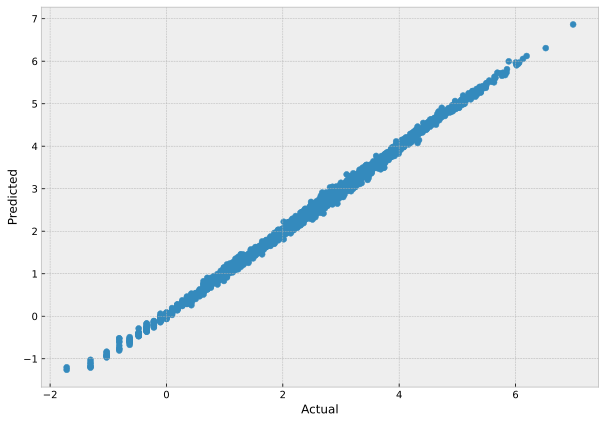

In [ ]:
plt.scatter(y_true, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

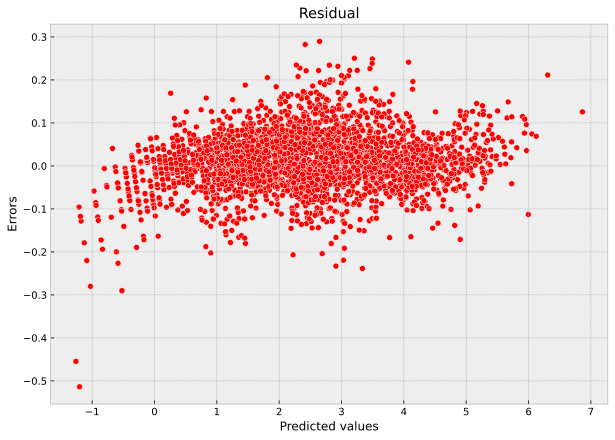

In [ ]:
errors = np.array(y_true) - np.array(y_pred)

sns.scatterplot(x=np.array(y_pred),y=errors, color='r').set(title='Residual')
plt.xlabel('Predicted values')
plt.ylabel('Errors')
plt.show()

###Comparing the performance with the previous approach

The evaluation metrics shows us that results of previous approach were more precise. However, the data preprocessing steps for the previous (regression-1) and current (regression-2) models have some differences. For regression-1, I removed the outlayers and applied StandartScaler fit on the entire dataset. Now I corrected these steps in order to prevent data leakage. As for this time, I'd say the results are quite good, the residuals are more or less randomly scattered around zero, so we can say the linear model is a good fit for the data.

##Classification task

The full EDA and DP with explanations can be found here: https://colab.research.google.com/drive/161nXkDCN4pW6uV-otbFycmGe9kAYgw_v?usp=sharing.

In [ ]:
df_cl = pd.read_csv('/content/gdrive/MyDrive/dataset_57_hypothyroid.csv')
df_cl.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

   TT4 T4U_measured   T4U FTI_measured  FTI TBG_measured TBG referral_source  \
0  125            t  1.14            t  109            f   ?            SVHC   
1  102            f     ?            f    ?            f   ?           other   
2  109            t  0.91            t  120            f   ?           other   
3  175            f     ?            f    ?            f   ?           other   
4   61            t  0.87            t   70            f   ?             SVI   

      Class  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  

[5 rows x 30 columns]

###Data preprocessing

Missing values seem to be marked as "?". Let's replace them with NaNs.

In [ ]:
df_cl=df_cl.replace({"?":np.NaN})

The feature `TBG` is empty so we can drop it.

In [ ]:
df_cl.drop(['TBG'], axis=1 , inplace=True)

Features `TSH_measured`, `T3_measured`, `TT4_measured`, `FTI_measured`, `TBG_measured`, `T4U_measured` are not important for our research. They can only show where the missing values are in the features `TSH`, `T3`, `TT4`, `FTI`, `TBG` and `T4U` respectively. We can drop them. Also, as far as I understand, `referral_source` means the source of the provided data, so it might not be a good feature for our research, I'll remove it too.

In [ ]:
df_cl.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'FTI_measured', 'TBG_measured', 'T4U_measured', 'referral_source'], axis=1 , inplace=True)

Let's define numeric and categorical features.

In [ ]:
df_cl[['age','TSH', 'T3','TT4','T4U', 'FTI']] = df_cl[['age','TSH', 'T3','TT4','T4U', 'FTI']].astype(float)

numeric_features = df_cl.select_dtypes('number').columns
categorical_features = df_cl.select_dtypes(np.object).columns.drop('Class')

Fixing some inconsistencies.

In [ ]:
df_cl['age'] = np.where((df_cl.age > 113), np.NaN, df_cl.age)

df_cl['sex'] = np.where((df_cl.sex.isnull()) & (df_cl.pregnant == 't'), 'F', df_cl.sex)

df_cl.drop(df_cl[(df_cl.pregnant == 't') & (df_cl.age > 73)].index, inplace=True)

Dropping rows with a lot of missing values.

In [ ]:
df_cl.drop(df_cl[df_cl.isnull().sum(axis=1) > 3].index, inplace=True)

Now we form the X and y datasets.

In [ ]:
X = df_cl.drop(['Class'], axis=1)
y = df_cl[['Class']]

y.value_counts()

Class                  
negative                   3258
compensated_hypothyroid     193
primary_hypothyroid          92
secondary_hypothyroid         2
dtype: int64

`secondary_hypothyroid` class is represented by only two observations. It's not enough for classification, I'll remove these rows.

In [ ]:
y = y[y['Class'] != 'secondary_hypothyroid']
X = X.loc[y.index]
y.value_counts()

Class                  
negative                   3258
compensated_hypothyroid     193
primary_hypothyroid          92
dtype: int64

Now we can split the data into train and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Fill missing values.

In [ ]:
imputer = SimpleImputer(strategy='median')

missing_features = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'age']
for feature in missing_features:
  X_train[feature] = imputer.fit_transform(X_train[[feature]])
  X_test[feature] = imputer.transform(X_test[[feature]])

In [ ]:
mode_sex = X_train['sex'].mode()[0]
X_train['sex'].fillna(mode_sex, inplace=True)
X_test['sex'].fillna(mode_sex, inplace=True)

Perform encoding.

In [ ]:
le = LabelEncoder()
ohe = OneHotEncoder()

for feature in categorical_features:
  X_train[feature] = le.fit_transform(X_train[feature])
  X_test[feature] = le.fit_transform(X_test[feature])

y_train = pd.DataFrame(le.fit_transform(y_train))
y_test = pd.DataFrame(le.fit_transform(y_test))

And scaling.

In [ ]:
scaler = RobustScaler()

X_train_scaled = X_train.copy().reset_index(drop=True)
X_test_scaled = X_test.copy().reset_index(drop=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train_scaled[numeric_features] = pd.DataFrame(scaler.fit_transform(X_train_scaled[numeric_features]))
X_test_scaled[numeric_features] = pd.DataFrame(scaler.transform(X_test_scaled[numeric_features]))

After that we can split the train dataset into train and validation parts.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=42, stratify=y_train)

We convert data to PyTorch tensors.

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test_scaled.values)

X_val = torch.FloatTensor(X_val.values)
y_val = torch.LongTensor(y_val[0].values)

y_train = torch.LongTensor(y_train[0].values)
y_test = torch.LongTensor(y_test[0].values)

And create DataLoader objects.

In [ ]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

###Model

Now we can create the model. It has three fully connected (linear) layers and two activation functions (sigmoid). The first layer takes 21 input features and outputs n_hidden_neurons. The second layer also has n_hidden_neurons input and output, and the third layer takes n_hidden_neurons input and outputs 3 classes since this is a multiclass classification problem. The softmax function is applied to the output of the last layer to obtain the predicted probabilities for each class.

In [ ]:
class HypothyroidModel(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(HypothyroidModel, self).__init__()

        self.fc1 = torch.nn.Linear(21, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

Here we instantiate the model and define the loss function, optimizer and the learning rate scheduler.

In [ ]:
model = HypothyroidModel(84)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1.0e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

model, _, _, _, _ = train_model(model, criterion, optimizer, scheduler, 200)

Epoch [1/200], Loss: 0.5817
Test Loss: 0.3233
Epoch [2/200], Loss: 0.3122
Test Loss: 0.3112
Epoch [3/200], Loss: 0.2906
Test Loss: 0.2892
Epoch [4/200], Loss: 0.2844
Test Loss: 0.2537
Epoch [5/200], Loss: 0.2391
Test Loss: 0.2307
Epoch [6/200], Loss: 0.2308
Test Loss: 0.1986
Epoch [7/200], Loss: 0.1867
Test Loss: 0.1758
Epoch [8/200], Loss: 0.1575
Test Loss: 0.1506
Epoch [9/200], Loss: 0.1441
Test Loss: 0.1414
Epoch [10/200], Loss: 0.1326
Test Loss: 0.1281
Epoch [11/200], Loss: 0.1263
Test Loss: 0.1177
Epoch [12/200], Loss: 0.1218
Test Loss: 0.1154
Epoch [13/200], Loss: 0.1078
Test Loss: 0.1109
Epoch [14/200], Loss: 0.1055
Test Loss: 0.1122
Epoch [15/200], Loss: 0.0999
Test Loss: 0.1046
Epoch [16/200], Loss: 0.0969
Test Loss: 0.1037
Epoch [17/200], Loss: 0.1033
Test Loss: 0.0960
Epoch [18/200], Loss: 0.0967
Test Loss: 0.0996
Epoch [19/200], Loss: 0.0972
Test Loss: 0.0968
Epoch [20/200], Loss: 0.1020
Test Loss: 0.0928
Epoch [21/200], Loss: 0.0840
Test Loss: 0.0956
Epoch [22/200], Loss: 

Now we can make predictions.

In [ ]:
y_true, y_pred = test_model(model, criterion, 'classification')

Test Loss: 0.0502
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        48
           1       0.99      0.99      0.99       815
           2       0.80      0.87      0.83        23

    accuracy                           0.98       886
   macro avg       0.89      0.92      0.90       886
weighted avg       0.98      0.98      0.98       886

[[ 43   4   1]
 [  4 807   4]
 [  2   1  20]]


We can see that the worst metrics gives the class with the least number of observations.

###Comparing the performance with the previous approach

The current results are better than those of most models in HW Classification-1 (Logistic Regression, Support Vector Machine, K Neighbors) even without additional pre-processing such as over/under sampling or dimensionality reduction. However, the accuracy of the RandomForest model is slightly higher.

#CV part

In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/hotdog__not_hotdog.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/')

print('After zip extraction:')
print(os.listdir("/content/"))

After zip extraction:
['.config', 'gdrive', 'hotdog__not_hotdog', 'sample_data']


In [ ]:
data_root = '/content/hotdog__not_hotdog/'
print(os.listdir(data_root))

['train', 'test']


We can define the data augmentation and normalization transformations for the training and testing datasets using the `transforms.Compose` function from the torchvision.transforms module:

`Resize((382, 382))` resizes the images to have a height and width of 382 pixels.

`RandomHorizontalFlip` and `RandomVerticalFlip` randomly flip the images with a probability of 0.5.

`ToTensor` converts the image data from a PIL Image object with pixel values ranging from 0 to 255 to a PyTorch tensor with pixel values ranging from 0.0 to 1.0.

`Normalize` normalizes the image data by subtracting the mean and dividing by the standard deviation. The mean and standard deviation values here are precomputed and commonly used for pre-trained models in computer vision.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((382, 382)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((382, 382)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(data_root + 'train', train_transforms)
test_dataset = torchvision.datasets.ImageFolder(data_root + 'test', test_transforms)

We can see that train dataset has only 498 observations. I'll split the test dataset into two equal parts: validation and test.

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 498
    Root location: /content/hotdog__not_hotdog/train
    StandardTransform
Transform: Compose(
               Resize(size=(382, 382), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: /content/hotdog__not_hotdog/test
    StandardTransform
Transform: Compose(
               Resize(size=(382, 382), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
generator = torch.Generator().manual_seed(42)
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [250, 250], generator = generator)

Now we can create dataloaders.

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

Let's take a look at the data.

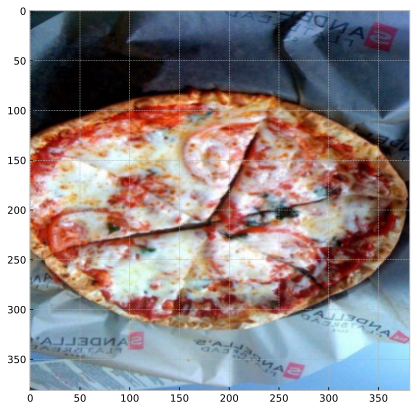

In [ ]:
X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

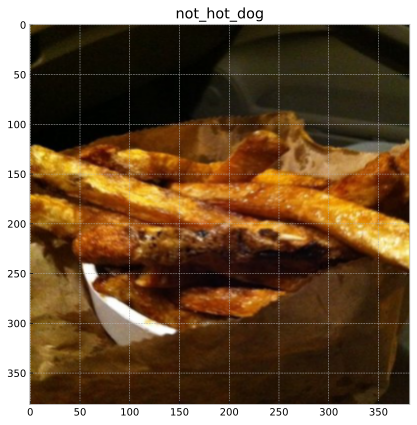

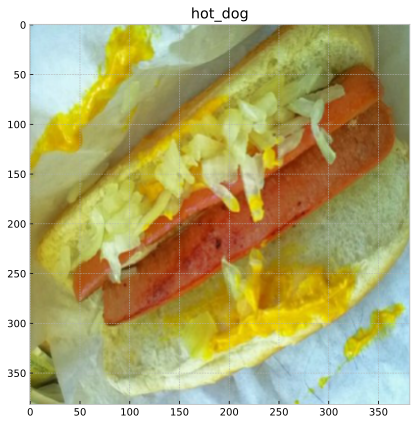

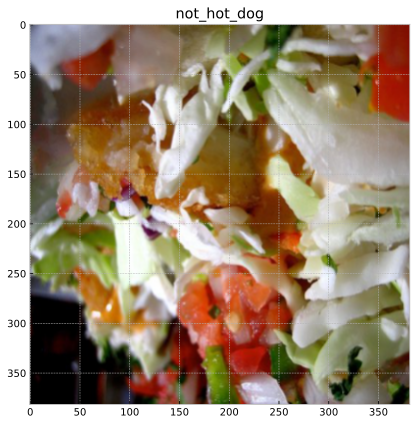

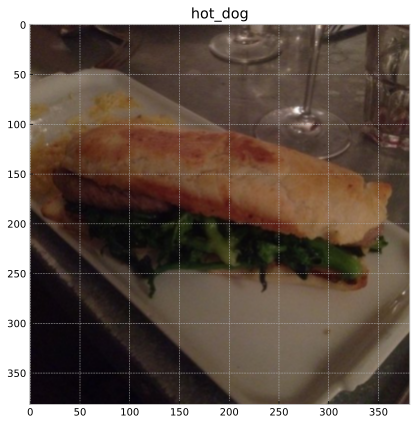

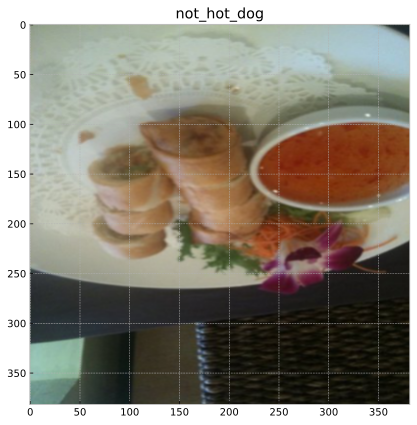

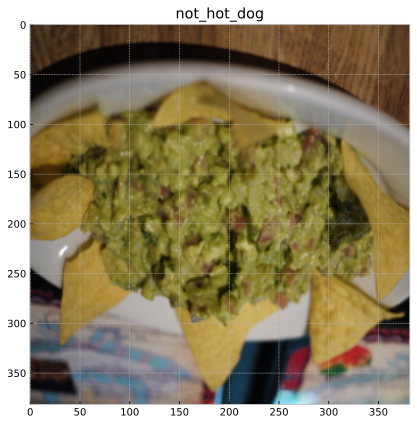

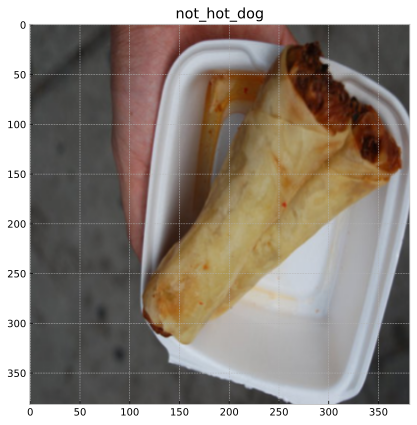

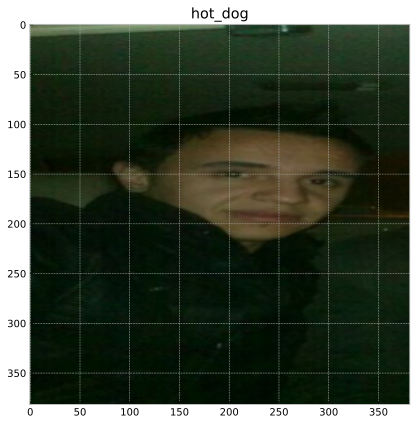

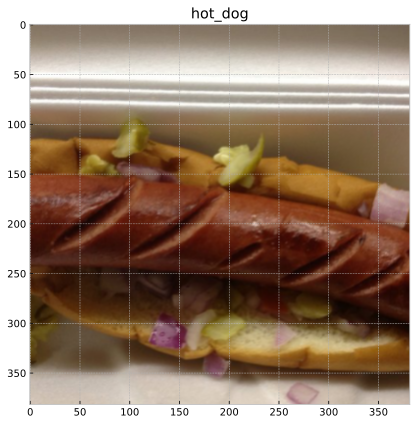

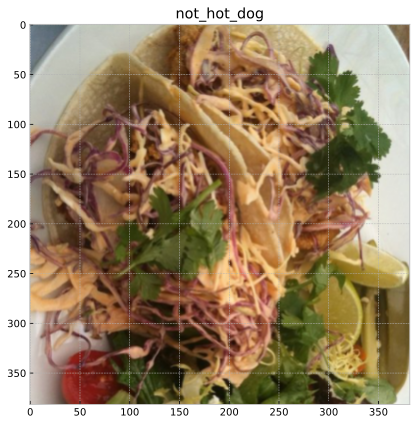

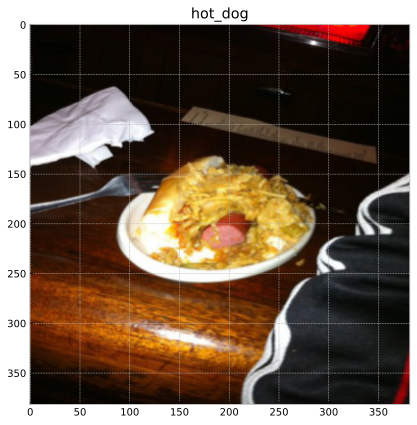

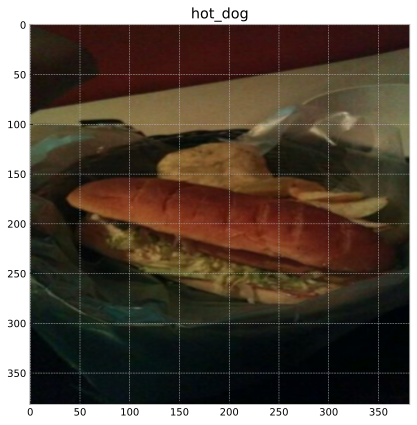

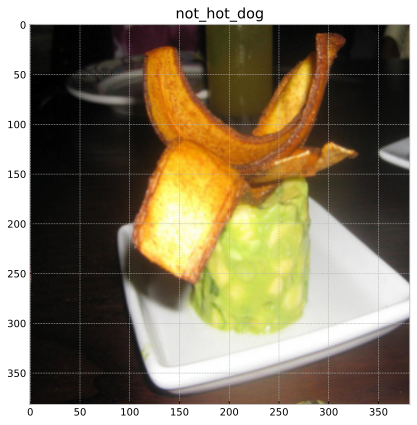

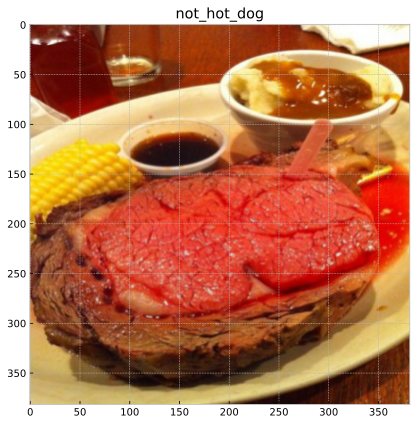

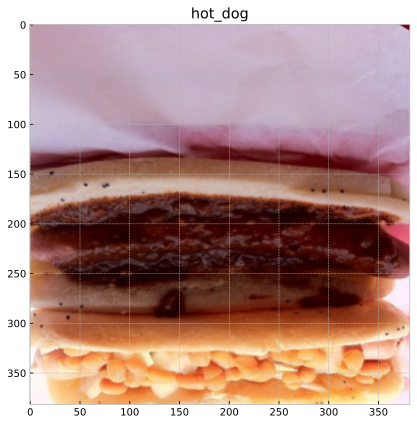

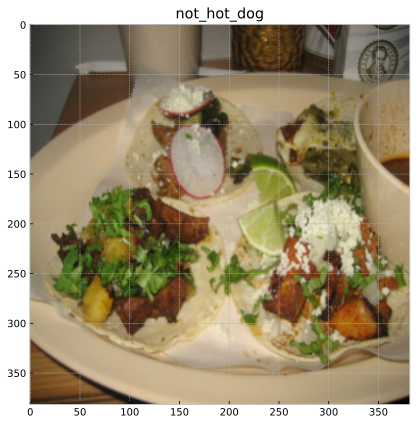

In [ ]:
class_names = ['hot_dog', 'not_hot_dog']

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_loader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

To speed up the process of training, I'll use GPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Pre-trained model

I'll use ResNet18 model with pre-trained weights freezing all the convolutional layers (by disabling grad). At the end there will be a linear classification layer with 2 output neurons to the model.

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12, 'classification')

Epoch 0/11:


100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

Train Loss: 0.5843



100%|██████████| 16/16 [00:04<00:00,  3.21it/s]

Val Loss: 0.3701
Epoch 1/11:



100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

Train Loss: 0.3290



100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

Val Loss: 0.3308
Epoch 2/11:



100%|██████████| 32/32 [00:06<00:00,  4.61it/s]

Train Loss: 0.2529



100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

Val Loss: 0.2509
Epoch 3/11:



100%|██████████| 32/32 [00:06<00:00,  4.74it/s]

Train Loss: 0.2300



100%|██████████| 16/16 [00:04<00:00,  3.48it/s]

Val Loss: 0.2457
Epoch 4/11:



100%|██████████| 32/32 [00:07<00:00,  4.16it/s]

Train Loss: 0.1899



100%|██████████| 16/16 [00:04<00:00,  3.66it/s]

Val Loss: 0.2412
Epoch 5/11:



100%|██████████| 32/32 [00:08<00:00,  3.60it/s]

Train Loss: 0.2065



100%|██████████| 16/16 [00:04<00:00,  3.62it/s]

Val Loss: 0.5058
Epoch 6/11:



100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

Train Loss: 0.2224



100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

Val Loss: 0.3101
Epoch 7/11:



100%|██████████| 32/32 [00:10<00:00,  3.04it/s]

Train Loss: 0.1769



100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

Val Loss: 0.4668
Epoch 8/11:



100%|██████████| 32/32 [00:07<00:00,  4.04it/s]

Train Loss: 0.1667



100%|██████████| 16/16 [00:04<00:00,  3.46it/s]

Val Loss: 0.3249
Epoch 9/11:



100%|██████████| 32/32 [00:08<00:00,  3.99it/s]

Train Loss: 0.2214



100%|██████████| 16/16 [00:04<00:00,  3.72it/s]

Val Loss: 0.3396
Epoch 10/11:



100%|██████████| 32/32 [00:08<00:00,  3.70it/s]

Train Loss: 0.1827



100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

Val Loss: 0.5591
Epoch 11/11:



100%|██████████| 32/32 [00:09<00:00,  3.52it/s]

Train Loss: 0.1787



100%|██████████| 16/16 [00:04<00:00,  3.68it/s]

Val Loss: 0.2724


Now we can visualize the learning curves.

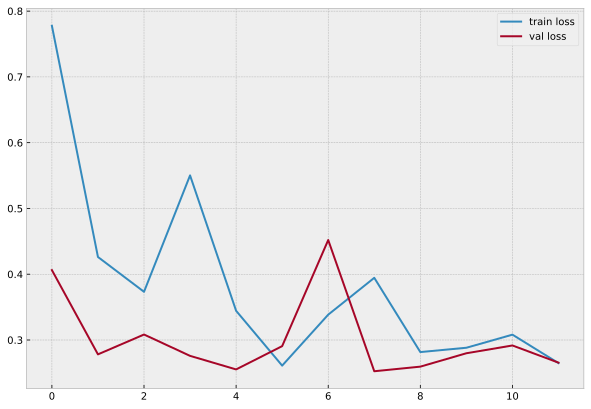

In [ ]:
#Loss curve
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'val loss')
plt.legend(loc='best')
plt.show()

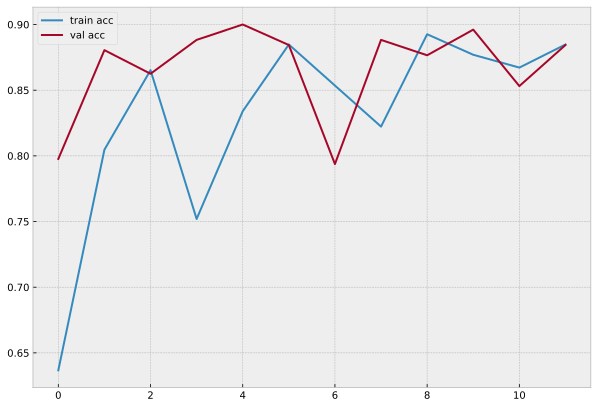

In [ ]:
#Accuracy curve
plt.plot(train_accs, label = 'train acc')
plt.plot(val_accs, label = 'val acc')
plt.legend(loc='best')
plt.show()

And test the model.

In [ ]:
y_true, y_pred = test_model(model, criterion, 'classification')

100%|██████████| 16/16 [00:07<00:00,  2.02it/s]

Test Loss: 0.2404
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       119
           1       0.92      0.88      0.90       131

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250

[[109  10]
 [ 16 115]]


The accuracy of our model is 90%. So, 9 out of 10 images are predicted correctly.

Now I'd like to try more complicated version of this model - ResNet50.

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12, 'classification', True)

Epoch 0/11:


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]

Train Loss: 0.6524



100%|██████████| 16/16 [00:07<00:00,  2.16it/s]

Val Loss: 0.2434
Epoch 1/11:



100%|██████████| 32/32 [00:10<00:00,  2.98it/s]

Train Loss: 0.2943



100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

Val Loss: 0.2286
Epoch 2/11:



100%|██████████| 32/32 [00:11<00:00,  2.78it/s]

Train Loss: 0.2975



100%|██████████| 16/16 [00:08<00:00,  1.81it/s]

Val Loss: 0.3291
Epoch 3/11:



100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

Train Loss: 0.2619



100%|██████████| 16/16 [00:08<00:00,  1.97it/s]

Val Loss: 0.2192
Epoch 4/11:



100%|██████████| 32/32 [00:13<00:00,  2.41it/s]

Train Loss: 0.1924



100%|██████████| 16/16 [00:08<00:00,  1.97it/s]

Val Loss: 0.2729
Epoch 5/11:



100%|██████████| 32/32 [00:11<00:00,  2.76it/s]

Train Loss: 0.1538



100%|██████████| 16/16 [00:08<00:00,  1.89it/s]

Val Loss: 0.5653
Epoch 6/11:



100%|██████████| 32/32 [00:11<00:00,  2.77it/s]

Train Loss: 0.1652



100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

Val Loss: 0.2685
Epoch 7/11:



100%|██████████| 32/32 [00:10<00:00,  2.96it/s]

Train Loss: 0.1640



100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

Val Loss: 0.3156
Epoch 8/11:



100%|██████████| 32/32 [00:12<00:00,  2.67it/s]

Train Loss: 0.1943



100%|██████████| 16/16 [00:07<00:00,  2.11it/s]

Val Loss: 0.2417
Epoch 9/11:



100%|██████████| 32/32 [00:13<00:00,  2.41it/s]

Train Loss: 0.1029



100%|██████████| 16/16 [00:09<00:00,  1.70it/s]

Val Loss: 0.3825
Epoch 10/11:



100%|██████████| 32/32 [00:14<00:00,  2.20it/s]

Train Loss: 0.1403



100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

Val Loss: 0.4500
Epoch 11/11:



100%|██████████| 32/32 [00:12<00:00,  2.65it/s]

Train Loss: 0.1335



100%|██████████| 16/16 [00:09<00:00,  1.63it/s]

Val Loss: 0.3054


In [ ]:
y_true, y_pred = test_model(model, criterion, 'classification', True)

100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

Test Loss: 0.3447
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       119
           1       0.86      0.96      0.91       131

    accuracy                           0.90       250
   macro avg       0.90      0.89      0.89       250
weighted avg       0.90      0.90      0.90       250

[[ 98  21]
 [  5 126]]


We can see that adding layers to the model didn't give any improvement. This model has better 1-class prediction accuracy, while the previous model is better at predicting class 0.

##Creating the model

We can try to create our own model for classification. As a base, I'll use convolutional blocks with batch-normalization and ReLU as activation function.

In [ ]:
class HotDogClassifier(torch.nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()


        self.c1 = self.conv(3, 64)
        self.c2 = self.conv(64, 128)
        self.c3 = self.conv(128, 256)
        self.c4 = self.conv(256, 256)
        self.c5 = self.conv(256, 128)
        self.lastcnn = torch.nn.Conv2d(in_channels=128, out_channels=2, kernel_size=28, stride=1, padding=0)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear = torch.nn.Linear(1, 2)


    def forward(self, x):
        x = self.c1(x)
        x = self.maxpool(x)

        x = self.c2(x)
        x = self.maxpool(x)

        x = self.c3(x)

        x = self.c4(x)
        x = self.maxpool(x)

        x = self.c5(x)
        x = self.lastcnn(x)

        x = x.squeeze()

        return x


    def conv(self, ch_in, ch_out, kernel_size=3, stride=1, padding=1):
        seq_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(num_features=ch_out),
            torch.nn.ReLU(),
        )

        return seq_block

This time, the pre-processing step is slightly different.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(data_root + 'train', train_transforms)
test_dataset = torchvision.datasets.ImageFolder(data_root + 'test', test_transforms)

In [ ]:
generator = torch.Generator().manual_seed(42)
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [250, 250], generator = generator)

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
model = HotDogClassifier()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, 50, 'classification', True)

Epoch 0/49:


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]

train Loss: 4.9739 Acc: 0.5558



100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

val Loss: 4.1730 Acc: 0.4585
Epoch 1/49:



100%|██████████| 8/8 [00:18<00:00,  2.31s/it]

train Loss: 3.3674 Acc: 0.5291



100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

val Loss: 5.0392 Acc: 0.5211
Epoch 2/49:



100%|██████████| 8/8 [00:15<00:00,  1.99s/it]

train Loss: 3.6870 Acc: 0.5385



100%|██████████| 4/4 [00:13<00:00,  3.33s/it]

val Loss: 1.9474 Acc: 0.5935
Epoch 3/49:



100%|██████████| 8/8 [00:18<00:00,  2.27s/it]

train Loss: 3.1500 Acc: 0.5410



100%|██████████| 4/4 [00:09<00:00,  2.29s/it]

val Loss: 2.9647 Acc: 0.5571
Epoch 4/49:



100%|██████████| 8/8 [00:17<00:00,  2.22s/it]

train Loss: 2.6120 Acc: 0.5254



100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

val Loss: 1.9525 Acc: 0.5321
Epoch 5/49:



100%|██████████| 8/8 [00:20<00:00,  2.54s/it]

train Loss: 1.7098 Acc: 0.5889



100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

val Loss: 2.1036 Acc: 0.4472
Epoch 6/49:



100%|██████████| 8/8 [00:19<00:00,  2.43s/it]

train Loss: 1.3404 Acc: 0.5968



100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

val Loss: 1.1472 Acc: 0.4957
Epoch 7/49:



100%|██████████| 8/8 [00:15<00:00,  1.92s/it]

train Loss: 1.0698 Acc: 0.6102



100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

val Loss: 0.9600 Acc: 0.6138
Epoch 8/49:



100%|██████████| 8/8 [00:20<00:00,  2.61s/it]

train Loss: 1.2176 Acc: 0.6258



100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

val Loss: 1.0063 Acc: 0.5982
Epoch 9/49:



100%|██████████| 8/8 [00:17<00:00,  2.14s/it]

train Loss: 0.8828 Acc: 0.6531



100%|██████████| 4/4 [00:13<00:00,  3.46s/it]

val Loss: 0.9742 Acc: 0.6064
Epoch 10/49:



100%|██████████| 8/8 [00:17<00:00,  2.13s/it]

train Loss: 0.9224 Acc: 0.6295



100%|██████████| 4/4 [00:14<00:00,  3.62s/it]

val Loss: 0.8521 Acc: 0.5900
Epoch 11/49:



100%|██████████| 8/8 [00:16<00:00,  2.07s/it]

train Loss: 0.7523 Acc: 0.6615



100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

val Loss: 0.8714 Acc: 0.5399
Epoch 12/49:



100%|██████████| 8/8 [00:19<00:00,  2.47s/it]

train Loss: 0.7731 Acc: 0.6236



100%|██████████| 4/4 [00:14<00:00,  3.68s/it]

val Loss: 0.8126 Acc: 0.6033
Epoch 13/49:



100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

train Loss: 0.7420 Acc: 0.6366



100%|██████████| 4/4 [00:12<00:00,  3.07s/it]

val Loss: 0.8229 Acc: 0.5783
Epoch 14/49:



100%|██████████| 8/8 [00:19<00:00,  2.39s/it]

train Loss: 0.7430 Acc: 0.6592



100%|██████████| 4/4 [00:11<00:00,  2.96s/it]

val Loss: 0.8163 Acc: 0.6017
Epoch 15/49:



100%|██████████| 8/8 [00:16<00:00,  2.11s/it]

train Loss: 0.6443 Acc: 0.6651



100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

val Loss: 0.7879 Acc: 0.6029
Epoch 16/49:



100%|██████████| 8/8 [00:19<00:00,  2.41s/it]

train Loss: 0.6658 Acc: 0.6752



100%|██████████| 4/4 [00:10<00:00,  2.61s/it]

val Loss: 0.9240 Acc: 0.5696
Epoch 17/49:



100%|██████████| 8/8 [00:18<00:00,  2.35s/it]

train Loss: 0.6516 Acc: 0.6796



100%|██████████| 4/4 [00:12<00:00,  3.00s/it]

val Loss: 0.7846 Acc: 0.5861
Epoch 18/49:



100%|██████████| 8/8 [00:16<00:00,  2.08s/it]

train Loss: 0.6402 Acc: 0.6570



100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

val Loss: 0.7605 Acc: 0.6165
Epoch 19/49:



100%|██████████| 8/8 [00:18<00:00,  2.31s/it]

train Loss: 0.5697 Acc: 0.7058



100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

val Loss: 0.7767 Acc: 0.5888
Epoch 20/49:



100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

train Loss: 0.6178 Acc: 0.7200



100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

val Loss: 0.8427 Acc: 0.6146
Epoch 21/49:



100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

train Loss: 0.6247 Acc: 0.7011



100%|██████████| 4/4 [00:18<00:00,  4.55s/it]

val Loss: 0.7704 Acc: 0.6099
Epoch 22/49:



100%|██████████| 8/8 [00:20<00:00,  2.56s/it]

train Loss: 0.5896 Acc: 0.7063



100%|██████████| 4/4 [00:10<00:00,  2.53s/it]

val Loss: 0.7529 Acc: 0.5978
Epoch 23/49:



100%|██████████| 8/8 [00:16<00:00,  2.04s/it]

train Loss: 0.5556 Acc: 0.6960



100%|██████████| 4/4 [00:10<00:00,  2.66s/it]

val Loss: 0.7547 Acc: 0.5857
Epoch 24/49:



100%|██████████| 8/8 [00:19<00:00,  2.46s/it]

train Loss: 0.5477 Acc: 0.7326



100%|██████████| 4/4 [00:12<00:00,  3.19s/it]

val Loss: 0.7533 Acc: 0.6052
Epoch 25/49:



100%|██████████| 8/8 [00:17<00:00,  2.16s/it]

train Loss: 0.5768 Acc: 0.6958



100%|██████████| 4/4 [00:12<00:00,  3.12s/it]

val Loss: 0.7462 Acc: 0.6087
Epoch 26/49:



100%|██████████| 8/8 [00:16<00:00,  2.06s/it]

train Loss: 0.5788 Acc: 0.6941



100%|██████████| 4/4 [00:10<00:00,  2.53s/it]

val Loss: 0.7415 Acc: 0.6169
Epoch 27/49:



100%|██████████| 8/8 [00:18<00:00,  2.27s/it]

train Loss: 0.5710 Acc: 0.6947



100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

val Loss: 0.7441 Acc: 0.5943
Epoch 28/49:



100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

train Loss: 0.5882 Acc: 0.6955



100%|██████████| 4/4 [00:10<00:00,  2.64s/it]

val Loss: 0.7432 Acc: 0.6044
Epoch 29/49:



100%|██████████| 8/8 [00:16<00:00,  2.10s/it]

train Loss: 0.5796 Acc: 0.7044



100%|██████████| 4/4 [00:13<00:00,  3.45s/it]

val Loss: 0.7386 Acc: 0.5931
Epoch 30/49:



100%|██████████| 8/8 [00:21<00:00,  2.70s/it]

train Loss: 0.5363 Acc: 0.7415



100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

val Loss: 0.7466 Acc: 0.6021
Epoch 31/49:



100%|██████████| 8/8 [00:16<00:00,  2.01s/it]

train Loss: 0.5618 Acc: 0.7095



100%|██████████| 4/4 [00:10<00:00,  2.64s/it]

val Loss: 0.7325 Acc: 0.6044
Epoch 32/49:



100%|██████████| 8/8 [00:23<00:00,  2.97s/it]

train Loss: 0.5866 Acc: 0.6896



100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

val Loss: 0.7327 Acc: 0.5978
Epoch 33/49:



100%|██████████| 8/8 [00:17<00:00,  2.19s/it]

train Loss: 0.5304 Acc: 0.7379



100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

val Loss: 0.7336 Acc: 0.6009
Epoch 34/49:



100%|██████████| 8/8 [00:18<00:00,  2.27s/it]

train Loss: 0.5519 Acc: 0.6885



100%|██████████| 4/4 [00:12<00:00,  3.13s/it]

val Loss: 0.7303 Acc: 0.6005
Epoch 35/49:



100%|██████████| 8/8 [00:17<00:00,  2.21s/it]

train Loss: 0.5607 Acc: 0.6985



100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

val Loss: 0.7298 Acc: 0.6044
Epoch 36/49:



100%|██████████| 8/8 [00:22<00:00,  2.75s/it]

train Loss: 0.5640 Acc: 0.6997



100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

val Loss: 0.7289 Acc: 0.5970
Epoch 37/49:



100%|██████████| 8/8 [00:20<00:00,  2.55s/it]

train Loss: 0.5622 Acc: 0.7167



100%|██████████| 4/4 [00:12<00:00,  3.25s/it]

val Loss: 0.7333 Acc: 0.6044
Epoch 38/49:



100%|██████████| 8/8 [00:19<00:00,  2.48s/it]

train Loss: 0.5806 Acc: 0.7116



100%|██████████| 4/4 [00:12<00:00,  3.17s/it]

val Loss: 0.7294 Acc: 0.5970
Epoch 39/49:



100%|██████████| 8/8 [00:18<00:00,  2.27s/it]

train Loss: 0.5774 Acc: 0.6958



100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

val Loss: 0.7306 Acc: 0.6005
Epoch 40/49:



100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

train Loss: 0.5318 Acc: 0.7390



100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

val Loss: 0.7287 Acc: 0.5927
Epoch 41/49:



100%|██████████| 8/8 [00:17<00:00,  2.21s/it]

train Loss: 0.5524 Acc: 0.7166



100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

val Loss: 0.7312 Acc: 0.5927
Epoch 42/49:



100%|██████████| 8/8 [00:19<00:00,  2.45s/it]

train Loss: 0.5377 Acc: 0.7356



100%|██████████| 4/4 [00:14<00:00,  3.74s/it]

val Loss: 0.7303 Acc: 0.6009
Epoch 43/49:



100%|██████████| 8/8 [00:18<00:00,  2.28s/it]

train Loss: 0.5675 Acc: 0.7148



100%|██████████| 4/4 [00:12<00:00,  3.04s/it]

val Loss: 0.7334 Acc: 0.5892
Epoch 44/49:



100%|██████████| 8/8 [00:20<00:00,  2.52s/it]

train Loss: 0.5387 Acc: 0.7173



100%|██████████| 4/4 [00:13<00:00,  3.43s/it]

val Loss: 0.7348 Acc: 0.5931
Epoch 45/49:



100%|██████████| 8/8 [00:18<00:00,  2.28s/it]

train Loss: 0.5408 Acc: 0.7170



100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

val Loss: 0.7306 Acc: 0.6009
Epoch 46/49:



100%|██████████| 8/8 [00:17<00:00,  2.24s/it]

train Loss: 0.5135 Acc: 0.7451



100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

val Loss: 0.7302 Acc: 0.6009
Epoch 47/49:



100%|██████████| 8/8 [00:19<00:00,  2.49s/it]

train Loss: 0.5445 Acc: 0.7370



100%|██████████| 4/4 [00:11<00:00,  2.88s/it]

val Loss: 0.7286 Acc: 0.6048
Epoch 48/49:



100%|██████████| 8/8 [00:18<00:00,  2.36s/it]

train Loss: 0.5417 Acc: 0.7267



100%|██████████| 4/4 [00:14<00:00,  3.67s/it]

val Loss: 0.7279 Acc: 0.6009
Epoch 49/49:



100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

train Loss: 0.5751 Acc: 0.7145



100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

val Loss: 0.7270 Acc: 0.6009


In [ ]:
y_true, y_pred = test_model(model, criterion, 'classification', True)

100%|██████████| 4/4 [00:13<00:00,  3.38s/it]

Test Loss: 0.7671
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       119
           1       0.63      0.51      0.56       131

    accuracy                           0.58       250
   macro avg       0.59      0.59      0.58       250
weighted avg       0.59      0.58      0.58       250

[[79 40]
 [64 67]]


It seems we have poor results. The model needs to be improved.

#Conclusions

Using pre-trained models for image classification can be very beneficial for several reasons. First, pre-trained models are already learned to recognize many different types of objects. It makes them more accurate and efficient in classifying images. Second, the process of adapting a pretrained model to a specific problem is faster than training a model from scratch. For example, we can make a binary classification by adding to pre-trained model just one layer to form output. Also, we can un-freeze some final pre-trained model layers to adjust the weights to fit the particular dataset, but I think it's not useful for our hotdog/not_hotdog problem.